## Stereo Model Calibration
from https://github.com/PacktPublishing/OpenCV-3-Computer-Vision-with-Python-Cookbook/blob/master/Chapter09/03%20Stereo%20rig%20calibration%20estimation%20of%20extrinsics.ipynb 

For data Acquisition, use cameragather.ipynb


In [128]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
import sys

In [129]:
PATTERN_SIZE = (8, 6) # size of chessboard pattern
# make sure to align right & left cameras in data gathering

test_data = "05_16_2025/lighttest_60pct" # starting from 'acq_data' folder
square_size = 25*0.6 #2.39 4.74 # in millimeters

# Test if files exist in the specified paths
import os
print("Current working directory:", os.getcwd())

output_path = os.path.join('calibr_results', test_data)
print("Output path:", output_path)

left_imgs = list(sorted(glob.glob(os.path.join('acq_data', test_data, 'camera0_*.jpg'))))
right_imgs = list(sorted(glob.glob(os.path.join('acq_data', test_data, 'camera1_*.jpg'))))
assert len(left_imgs) == len(right_imgs)
print(len(left_imgs), 'images found')

Current working directory: c:\Users\liams\Documents\GitHub\ProjectSurgeryHernia\scene3d\stereo_utils\calibration
Output path: calibr_results\05_16_2025/lighttest_60pct
7 images found


Found corners in 7 images
Annotated images saved for sample 12.


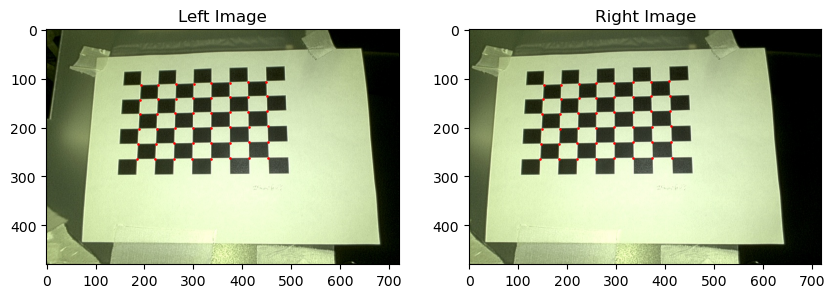

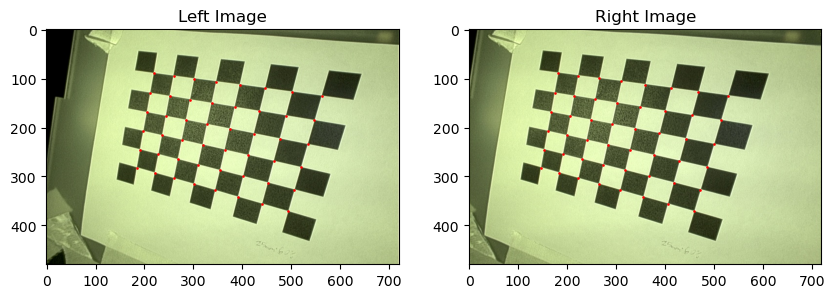

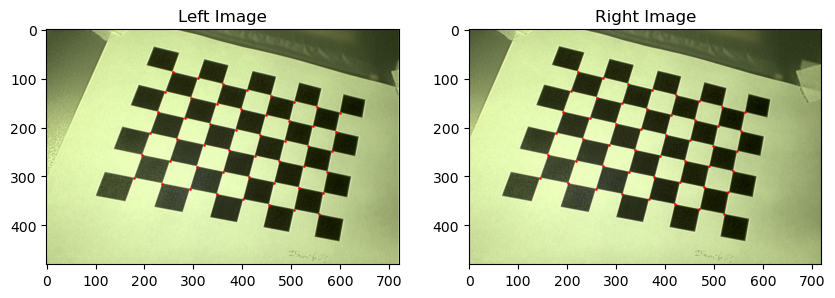

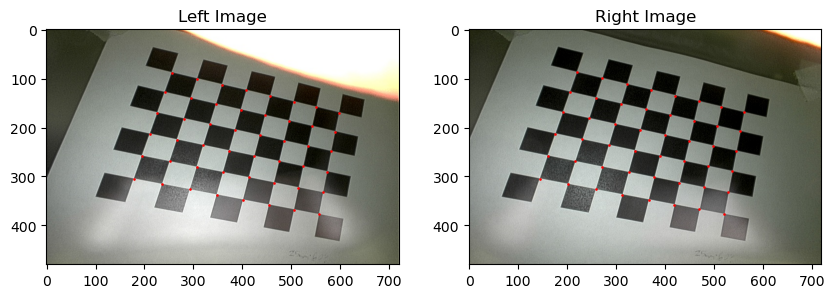

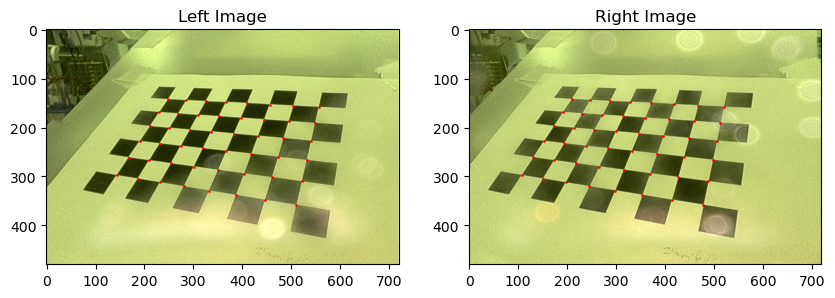

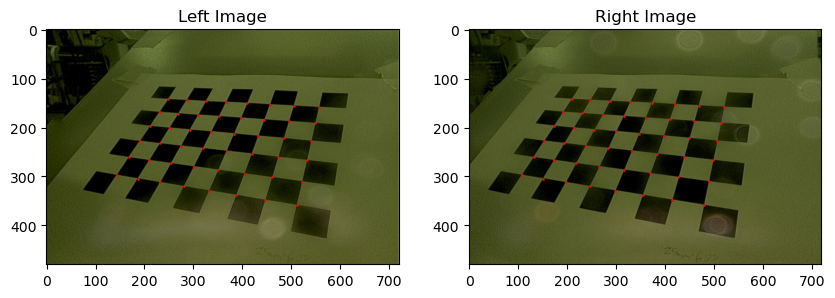

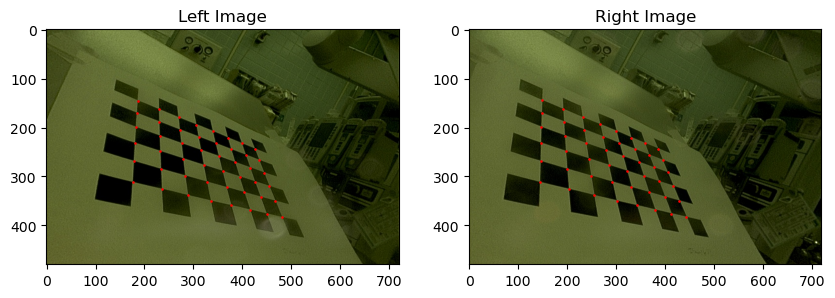

In [130]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
left_pts, right_pts = [], []
img_size = None

for left_img_path, right_img_path in zip(left_imgs, right_imgs):
    left_img = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
    right_img = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)
    if img_size is None:
        img_size = (left_img.shape[1], left_img.shape[0])
    
    res_left, corners_left = cv2.findChessboardCornersSB(left_img, (8, 6), flags=cv2.CALIB_CB_EXHAUSTIVE)
    res_right, corners_right = cv2.findChessboardCornersSB(right_img, (8, 6), flags=cv2.CALIB_CB_EXHAUSTIVE)

    if not res_left:
        print('Failed to find left corners')
    if not res_right:
        print('Failed to find right corners')
    
    # Refine corner positions
    corners_left = cv2.cornerSubPix(left_img, corners_left, (8, 6), (-1,-1),
                                    criteria)
    corners_right = cv2.cornerSubPix(right_img, corners_right, (8, 6), (-1,-1), 
                                     criteria)
    
    left_pts.append(corners_left)
    right_pts.append(corners_right)

print('Found corners in', len(left_pts), 'images')
assert len(left_pts) == len(right_pts)

# Save the annotated left and right images from sample 12 for future testing
sample_index = min(5, (len(left_imgs)-1))  # Use the first sample for testing
annotated_left_img = cv2.imread(left_imgs[sample_index])
annotated_right_img = cv2.imread(right_imgs[sample_index])
cv2.drawChessboardCorners(annotated_left_img, PATTERN_SIZE, left_pts[sample_index], res_left)
cv2.drawChessboardCorners(annotated_right_img, PATTERN_SIZE, right_pts[sample_index], res_right)

# Save the images
cv2.imwrite(os.path.join(output_path, 'annotated_left.jpg'), annotated_left_img)
cv2.imwrite(os.path.join(output_path, 'annotated_right.jpg'), annotated_right_img)
print('Annotated images saved for sample 12.')

# Visualize the detected corners
for i, (left_img_path, right_img_path) in enumerate(zip(left_imgs, right_imgs)):
    left_img = cv2.imread(left_img_path)
    right_img = cv2.imread(right_img_path)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
    plt.scatter(left_pts[i][:, 0, 0], left_pts[i][:, 0, 1], c='r', s=0.75)
    plt.title('Left Image')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
    plt.scatter(right_pts[i][:, 0, 0], right_pts[i][:, 0, 1], c='r', s=0.75)
    plt.title('Right Image')
    
    plt.show()


In [131]:
# Define the size of a square in your checkerboard (e.g., 25mm)

# Prepare object points based on your physical checkerboard dimensions.
objp = np.zeros((PATTERN_SIZE[0] * PATTERN_SIZE[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:PATTERN_SIZE[0], 0:PATTERN_SIZE[1]].T.reshape(-1, 2)
objp = objp * square_size  # scale by the square size

# Repeat the object points for each image
pattern_points = [objp] * len(left_imgs)

In [132]:
err, Kl, Dl, Kr, Dr, R, T, E, F = cv2.stereoCalibrate(
    pattern_points, left_pts, right_pts, None, None, None, None, img_size, flags=0)

Tnorm = np.linalg.norm(T)
# Tnorm = np.sqrt(T[0]**2 + T[2]**2)
print(Tnorm)
Tnorm = np.array([Tnorm, 0, 0])
print(Tnorm)

4.280553291931761
[4.28055329 0.         0.        ]


In [133]:
print('Left camera:')
print(Kl)
print('Left camera distortion:')
print(Dl)
print('Right camera:')
print(Kr)
print('Right camera distortion:')
print(Dr)
print('Rotation matrix:')
print(R)
print('Translation:')
print(T)

Left camera:
[[597.8145501    0.         383.67894139]
 [  0.         497.83480641 234.41150491]
 [  0.           0.           1.        ]]
Left camera distortion:
[[-3.33823958e-02  4.69750137e-01 -2.35926364e-04  1.15611262e-04
  -1.54273657e+00]]
Right camera:
[[598.5648655    0.         332.61130956]
 [  0.         498.41476564 234.46324655]
 [  0.           0.           1.        ]]
Right camera distortion:
[[ 1.97474796e-02 -2.19392875e-01 -1.12231727e-03 -8.18694203e-04
   9.28765797e-01]]
Rotation matrix:
[[ 9.99999759e-01  5.85299925e-04  3.72434469e-04]
 [-5.85018837e-04  9.99999544e-01 -7.54392227e-04]
 [-3.72875845e-04  7.54174164e-04  9.99999646e-01]]
Translation:
[[4.27996999]
 [0.02400456]
 [0.06646188]]


## Saving Script
Use multitest for complete statistical analysis

In [134]:
import pandas as pd

os.makedirs(output_path, exist_ok=True)
np.save(os.path.join(output_path, 'stereo.npy'), {'Kl': Kl, 'Dl': Dl, 'Kr': Kr, 'Dr': Dr, 'R': R, 'T': Tnorm, 'E': E, 'F': F, 
                       'img_size': img_size, 'left_pts': left_pts, 'right_pts': right_pts})

# Load existing data if the file exists
# try:
#     existing_data = pd.read_excel('stereo_data.xlsxm', sheet_name=None)
# except FileNotFoundError:
#     existing_data = {}

# Create a new DataFrame for the new data
new_data = {
    'test': test,
    'Kl': Kl.flatten(),
    'Dl': Dl.flatten(),
    'Kr': Kr.flatten(),
    'Dr': Dr.flatten(),
    'R': R.flatten(),
    'T': T.flatten(),
    'E': E.flatten(),
    'F': F.flatten(),
    # 'img_size': list(img_size),
    # 'left_pts': [pt.flatten() for pt in left_pts],
    # 'right_pts': [pt.flatten() for pt in right_pts]
}
# Convert the new data to a DataFrame with each item in each entry as a separate row in a single column
new_df = pd.DataFrame([(k, v) for k, values in new_data.items() for v in (values.flatten() if isinstance(values, np.ndarray) else [values])], columns=['Parameter', 'Value'])

# # Write the new data to the Excel file, appending to existing data if present
# with pd.ExcelWriter('stereo_data.xlsxm', mode='a' if existing_data else 'w', engine='openpyxl', if_sheet_exists='overlay') as writer:
#     for sheet_name, data in existing_data.items():
#         data.to_excel(writer, sheet_name=sheet_name, index=False)
#     new_df.to_excel(writer, sheet_name='New Data', index=False, startcol=startcol)


with open(os.path.join(output_path, 'intrinsics.txt'), 'w') as f:
    for row in Kl:
        f.write(f"{row[0]:.6f} {row[1]:.6f} {row[2]:.6f} 0.000000\n")  # HAMLYN adds trailing 0s

with open(os.path.join(output_path, 'intrinsics_kr.txt'), 'w') as f:
    for row in Kr:
        f.write(f"{row[0]:.6f} {row[1]:.6f} {row[2]:.6f} 0.000000\n")

R_rows = R.tolist()
with open(os.path.join(output_path, 'extrinsics.txt'), 'w') as f:
    for i in range(3):
        row = R_rows[i]
        t_i = float(T[i])
        f.write(f"{row[0]:.6f} {row[1]:.6f} {row[2]:.6f} {t_i:.6f}\n")


C:\Users\liams\AppData\Local\Temp\ipykernel_35448\499589110.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_i = float(T[i])
